In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

from sklearn.neighbors import KNeighborsClassifier
import xgboost 
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import optuna


In [4]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [5]:
# Class와 feature의 상관관계를 바탕으로 선별된 15개의 feature
USE_FEATURES = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

In [6]:
# MaxAbsScaler 적용
SCALER = MaxAbsScaler()
SCALER.fit(train[USE_FEATURES])
train[USE_FEATURES] = SCALER.transform(train[USE_FEATURES])
val[USE_FEATURES] = SCALER.transform(val[USE_FEATURES])

In [7]:
train_df = train[USE_FEATURES]
val_df = val[USE_FEATURES]
val_label = val['Class']

KNN을 validation 데이터셋에 적합시키고 train 데이터셋의 정상/사기 여부를 예측한다.

In [8]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='brute', n_jobs=-1)
knn.fit(val_df.values, val_label.values)

KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     weights='distance')

In [9]:
probs = knn.predict_proba(train_df.values)

In [10]:
train_label = knn.predict(train_df)

c:\Users\pc\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [11]:
train_df['Class'] = train_label
train_df['Class'].value_counts()

C:\Users\pc\AppData\Local\Temp\ipykernel_14344\2737084557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Class'] = train_label


0    113721
1       121
Name: Class, dtype: int64

train 데이터셋에 총 121개의 사기 데이터가 존재하는 것으로 예측하였다.

In [12]:
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-0.024081,-0.018430,0.054637,0.023029,-0.011939,0.068825,0.017966,-0.112747,0.008509,0.059779,0.003562,-0.010622,-0.217236,0.052116,-0.014000,0
1,-0.017130,-0.002547,0.055247,-0.052349,-0.000245,0.047675,0.005394,-0.103247,-0.002252,-0.021680,0.009606,-0.018429,-0.079649,-0.032120,0.226764,0
2,-0.007552,0.013209,0.035161,-0.010203,0.009988,-0.001136,0.010809,-0.042331,-0.015220,0.128389,0.019397,-0.008778,0.030196,-0.002730,0.007920,0
3,-0.011422,0.019500,0.033105,-0.029846,0.022514,0.016365,0.025437,0.045807,0.051197,-0.059297,0.015710,-0.084737,-0.005722,-0.057383,-0.041323,0
4,-0.015854,0.003935,-0.003488,-0.016465,0.063339,0.142269,0.008402,-0.029183,-0.016819,-0.067496,-0.005953,0.004759,-0.015791,-0.023466,0.013700,0


### XGBoost Classifier
- 이전 데이터의 실제값과 예측값의 차이 (오차) 를 훈련 데이터에 투입하고 gradient를 이용하여 오류를 보완한다.
- 여러개의 decision tree를 병렬적으로 학습한다.
- 정규화 과정을 포함한다.

### XGBClassifier Hyperparameters
- booster: booster 종류 (gbtree(트리기반), gblinear(선형기반), dart)
- n_estimators: 나무의 개수
- eta(learning_rate): 학습 단계별 가중치 반영의 정도 (기울기)
- gamma: 트리에서 추가적으로 가지를 나눌지를 결정할 최소 손실 감소 값, 값이 클수록 과적합 감소 효과
- max_depth: 최대 깊이
- min_child_weight: child에서 필요한 모든 가중치의 합의 최소값
- subsample: 각 트리마다 샘플링 비율
- colsample_bytree/_bylevel/_bynode: 트리 생성시/각 level에서/각 node에서의 subsample 비율
- reg_lambda: L2 가중치
- reg_alpha: L1 가중치
- scale_pos_weight: 양/음의 가중치 균형 조절

In [33]:
X = train_df[USE_FEATURES]
Y = train_df['Class']

scale_pos_weight = np.sqrt(Y.value_counts()[0])/Y.value_counts()[1]
scale_pos_weight

2.78698713950336

### hyperparameter tuning
- 높은 학습률로 tree에 관한 hyperparameter를 먼저 탐색한다. 
- 이후 regularization parameter를 수정한다.
- 학습률을 낮춰서 반복한다. 

In [38]:
def optimization(trial: optuna.trial.Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc', # better in imbalanced dataset
        'booster': 'gbtree',
        'learning_rate': 0.1, 
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 5),
        'tree_method': 'gpu_hist', 'gpu_id': 0 # GPU
        }

    model = xgboost.XGBClassifier(**params, random_state=302, n_jobs=-1)
    
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=302) # StratifiedKFold + ShuffleSplit
    score = cross_val_score(model, X, Y, cv=cv, scoring='f1', n_jobs=-1)
    f1_mean = score.mean()

    return f1_mean

In [ ]:
optim = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
optim.optimize(optimization, n_trials=300)

In [ ]:
optuna.visualization.plot_optimization_history(optim)

In [42]:
print(optim.best_params)

{'n_estimators': 120, 'max_depth': 5, 'gamma': 0.9523289299800372, 'min_child_weight': 2, 'subsample': 0.7815734938368877, 'colsample_bytree': 0.9477798809598857, 'colsample_bylevel': 0.5919074048770124, 'colsample_bynode': 0.7268575923401924, 'reg_lambda': 0.9076017687189581, 'reg_alpha': 0.2981540758534452, 'scale_pos_weight': 5}


In [44]:
params = optim.best_params
model = xgboost.XGBClassifier(**params, objective='binary:logistic', eval_metric='auc', 
                              booster='gbtree', random_state=302)
model.fit(X, Y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5919074048770124,
              colsample_bynode=0.7268575923401924,
              colsample_bytree=0.9477798809598857, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.9523289299800372, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=302, ...)

In [46]:
val_pred = model.predict(val_df)

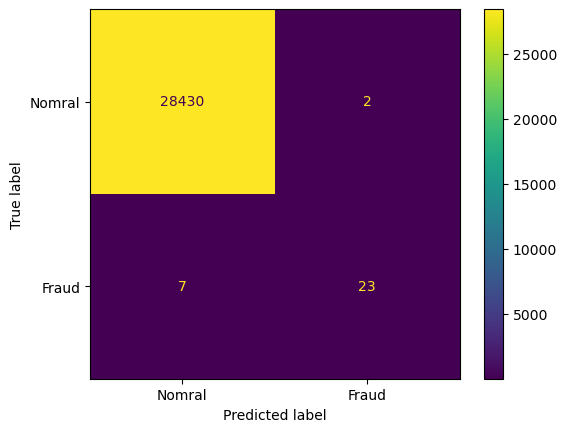

In [50]:
cm = confusion_matrix(val['Class'], val_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Fraud'])
disp.plot()

In [51]:
SCALER = MaxAbsScaler()
SCALER.fit(train[USE_FEATURES])
train[USE_FEATURES] = SCALER.transform(train[USE_FEATURES])
val[USE_FEATURES] = SCALER.transform(val[USE_FEATURES])

test[USE_FEATURES] = SCALER.transform(test[USE_FEATURES])
test_df = test[USE_FEATURES]

In [52]:
xgb_pred = model.predict(test_df)

In [53]:
print(f'Test Dataset Contamination Count: {xgb_pred[xgb_pred==1].sum()}')
print(f'Test Dataset Contamination Rate: {np.round(xgb_pred[xgb_pred==1].sum()/len(xgb_pred)*100, 2)}%')

Test Dataset Contamination Count: 8629
Test Dataset Contamination Rate: 6.06%


In [24]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Class'] = xgb_pred
submit.to_csv('submit/submit_Ensemble_KNN_XGboost_FI.csv', index=False)

In [25]:
submit['Class'].value_counts()

0    141877
1       626
Name: Class, dtype: int64